In [1]:
# IBL SWR detector
import os
import re
import subprocess
import numpy as np
import pandas as pd
from scipy import io, signal, stats
from scipy.signal import lfilter
import scipy.ndimage
from scipy.ndimage import gaussian_filter
from scipy.ndimage import gaussian_filter1d
from scipy import interpolate
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import ripple_detection
from ripple_detection import filter_ripple_band
import ripple_detection.simulate as ripsim  # for making our time vectors
from tqdm import tqdm
from iblatlas.atlas import AllenAtlas
from iblatlas.regions import BrainRegions
import spikeglx
from brainbox.io.one import load_channel_locations
from brainbox.io.spikeglx import Streamer
from brainbox.io.one import SpikeSortingLoader
from neurodsp.voltage import destripe_lfp
from ibllib.plots import Density
import time
import traceback
import logging
import logging.handlers
import sys
from fitter import Fitter, get_common_distributions, get_distributions
import pickle
from one.api import ONE


ONE.setup(base_url="https://openalyx.internationalbrainlab.org", silent=True)
one = ONE(password="international")

/home/acampbell/miniconda3/envs/ONE_ibl_env/lib/python3.10/site-packages/neurodsp/__init__.py:5: FutureWarning: neurodsp has been renamed to ibldsp and the old name will be deprecated on 01-Sep-2024.
  warn(


## Csd and Multitrace plot

In [84]:
from iblatlas.atlas import AllenAtlas
from iblatlas.regions import BrainRegions

ba = AllenAtlas()
br = BrainRegions()  # br is also an attribute of ba so could to br = ba.regions

In [85]:
# compute csd code
# try averaging between channels at the same depth, then providing that
# microns to microvolts means that microns can be in the same scale
def average_channels(electrode_data):
    """Calculate the average of every pair of even and odd channels"""
    nchan = electrode_data.shape[1]
    mask = np.full(nchan, False, dtype=bool)
    # print("mask length " + str(len(mask)))
    # Set True at even indices
    mask[::2] = True
    even_channels = electrode_data[:, mask]
    # print("even_channels shape" + str(even_channels.shape))
    odd_channels = electrode_data[:, ~mask]
    # print("odd_channels" + str(odd_channels.shape))
    # Calculate the average
    # averaged_data = np.average([even_channels, odd_channels_without_last], axis=0)

    averaged_data = (even_channels + odd_channels) / 2

    return averaged_data


def butterworth_filter_for_csd(
    LFP_array, lowcut=1.0, highcut=250.0, samplingfreq=2500.0, order=6
):

    nyquist = 0.5 * samplingfreq
    # Design the Butterworth bandpass filter
    # Design the Butterworth bandpass filter
    b, a = signal.butter(order, [lowcut / nyquist, highcut / nyquist], btype="band")

    # Apply the filter to all channels simultaneously using vectorized operations
    filtered_signal = signal.lfilter(b, a, LFP_array, axis=0)
    return filtered_signal


# Assuming you have your signal_array, b, and a defined as before
def finitimpresp_filter_for_csd(
    LFP_array, lowcut=1, highcut=250, samplingfreq=2500, filter_order=101
):

    nyquist = 0.5 * samplingfreq

    # Design the FIR bandpass filter using scipy.signal.firwin
    fir_coeff = signal.firwin(
        filter_order,
        [lowcut / nyquist, highcut / nyquist],
        pass_zero=False,
        fs=samplingfreq,
    )

    # Apply the FIR filter to your signal_array
    # filtered_signal = signal.convolve(LFP_array, fir_coeff, mode='same', method='auto')
    filtered_signal = signal.lfilter(fir_coeff, 1.0, LFP_array, axis=0)

    return filtered_signal


def compute_csd(lfp_data, spacing_between_channels, chan_rows):
    """
    Compute Current Source Density (CSD) from Local Field Potential (LFP) data.

    Parameters:
        lfp_data (numpy.ndarray): 2D array of LFP data, shape (n_channels, n_samples).
        spacing_between_channels (float): Distance (in micrometers) between adjacent channels.
        chan_rows list of int :  the index on the 2d dimension of lfp data for which channels are to be included

    Returns:
        csd_data (numpy.ndarray): 2D array of CSD data, shape (n_channels, n_samples).
    """
    # Ensure the input LFP data is a NumPy array
    lfp_data = np.array(lfp_data)
    lfp_data = lfp_data[:, chan_rows]

    lfp_data = finitimpresp_filter_for_csd(lfp_data)
    lfp_data = average_channels(lfp_data)

    # Get the number of channels and samples
    n_channels, n_samples = lfp_data.shape

    # Define the finite difference coefficients for second spatial derivative
    fd_coefficients = np.array([1, -2, 1]) / spacing_between_channels**2

    # Function to compute CSD for a single channel
    def compute_csd_single_channel(channel_data):
        return np.convolve(channel_data, fd_coefficients, mode="same")

    # Apply the second spatial derivative to each channel using apply_along_axis
    csd_data = np.apply_along_axis(compute_csd_single_channel, axis=0, arr=lfp_data)

    return csd_data


def exponential_smoothing_2d(data, alpha, axis):
    """
    Apply exponential smoothing to a 2D NumPy array along the specified axis.

    Parameters:
    - data: Input 2D NumPy array
    - alpha: Smoothing parameter (0 < alpha < 1)
    - axis: Axis along which to apply exponential smoothing (0 for rows, 1 for columns)

    Returns:
    - smoothed_data: Exponentially smoothed array
    """

    if axis not in (0, 1):
        raise ValueError("Axis must be 0 (rows) or 1 (columns).")

    smoothed_data = np.copy(data)

    if axis == 0:
        for i in range(data.shape[1]):
            smoothed_data[:, i] = exponential_smoothing(data[:, i], alpha)
    elif axis == 1:
        for i in range(data.shape[0]):
            smoothed_data[i, :] = exponential_smoothing(data[i, :], alpha)

    return smoothed_data


def exponential_smoothing(series, alpha):
    """
    Apply exponential smoothing to a 1D NumPy array.

    Parameters:
    - series: Input 1D NumPy array
    - alpha: Smoothing parameter (0 < alpha < 1)

    Returns:
    - smoothed_series: Exponentially smoothed array
    """

    smoothed_series = np.zeros_like(series)
    smoothed_series[0] = series[0]

    for t in range(1, len(series)):
        smoothed_series[t] = alpha * series[t] + (1 - alpha) * smoothed_series[t - 1]

    return smoothed_series

In [86]:
# pick a session based on largest ripple at lowest running speed
# and the peak probe it's on
# Convert speeds list to a pandas Series

speeds_series = pd.Series(speeds, name="speeds")

# Convert theta_data dict to a DataFrame
theta_df = pd.DataFrame(theta_powers)

# Reset the index of theta_df and test
theta_df = theta_df.reset_index(drop=True)

# Add speeds_series to all_swrs_df and reset index
all_swrs_df = all_swrs_df.assign(speeds=speeds_series)
all_swrs_df = all_swrs_df.reset_index(drop=True)

# Concatenate test and theta_df
all_swrs_df = pd.concat([all_swrs_df, theta_df], axis=1)

In [87]:
all_swrs_df.columns

Index(['start_time', 'end_time', 'probes_event_is_on', 'events_row_index',
       'global_peak_time', 'global_max_zscore', 'peak_probe', 'duration',
       'session_id', 'speeds', 'peakwindow_med', 'peakwindow_mean',
       'eventwindow_med', 'eventwindow_mean'],
      dtype='object')

In [88]:
# Sort by global_max_zscore in descending order
sorted_df = all_swrs_df

# Add quantile columns to sorted_df
sorted_df["speeds_quantile"] = pd.qcut(sorted_df["speeds"], q=4, labels=False)
sorted_df["peakwindow_mean_quantile"] = pd.qcut(
    sorted_df["peakwindow_mean"], q=4, labels=False
)

# Filter sorted_df to only include rows in the lowest quantiles of speeds and peakwindow_mean
lowest_quantiles_df = sorted_df[
    (sorted_df["speeds_quantile"] == 0) & (sorted_df["peakwindow_mean_quantile"] == 0)
]
lowest_quantiles_df = lowest_quantiles_df.sort_values(
    by="global_max_zscore", ascending=False
)

In [89]:
# Initialize a dictionary to store the counts
probe_counts = {}

# Iterate over the first 100 rows of the DataFrame
for _, row in lowest_quantiles_df.head(100).iterrows():
    probe_id = row["peak_probe"]
    session_id = row["session_id"]

    probes_list, probenames = one.eid2pid(session_id)
    probes_list = np.array(probes_list)
    probenames = np.array(probenames)

    probe_name = probenames[probes_list == probe_id]
    if probe_name.size > 0:
        probe_name = probe_name[0]
        collectionname = f"alf/{probe_name}/pykilosort"

        # Load the channels
        channels = one.load_object(session_id, "channels", collection=collectionname)
        channels.allen2017_25um_acronym = br.id2acronym(
            channels["brainLocationIds_ccf_2017"]
        )

        # Count the number of ca1 channels
        ca1_count = np.sum(channels["allen2017_25um_acronym"] == "CA1")

        # Update the count for this probe
        if probe_id in probe_counts:
            probe_counts[probe_id] = (probe_counts[probe_id][0] + ca1_count, session_id)
        else:
            probe_counts[probe_id] = (ca1_count, session_id)

# Find the probe with the most number of ca1 channels
max_probe = max(probe_counts, key=lambda x: probe_counts[x][0])

print(
    f"The probe with the most number of CA1 channels is: {max_probe} from session: {probe_counts[max_probe][1]}"
)

The probe with the most number of CA1 channels is: 30ac1320-d671-46fc-87ef-875cdfc6b4eb from session: edd22318-216c-44ff-bc24-49ce8be78374


In [90]:
# Initialize a dictionary to store the counts and scores
probe_counts_scores = {}

# Iterate over the first 100 rows of the DataFrame
for _, row in lowest_quantiles_df.head(100).iterrows():
    probe_id = row["peak_probe"]
    session_id = row["session_id"]
    global_max_zscore = row["global_max_zscore"]

    probes_list, probenames = one.eid2pid(session_id)
    probes_list = np.array(probes_list)
    probenames = np.array(probenames)

    probe_name = probenames[probes_list == probe_id]
    if probe_name.size > 0:
        probe_name = probe_name[0]
        collectionname = f"alf/{probe_name}/pykilosort"

        # Load the channels
        channels = one.load_object(session_id, "channels", collection=collectionname)
        channels.allen2017_25um_acronym = br.id2acronym(
            channels["brainLocationIds_ccf_2017"]
        )

        # Count the number of ca1 channels
        ca1_count = np.sum(channels["allen2017_25um_acronym"] == "CA1")

        # Update the count and score for this probe
        if probe_id in probe_counts_scores:
            probe_counts_scores[probe_id].append((ca1_count, global_max_zscore, row))
        else:
            probe_counts_scores[probe_id] = [(ca1_count, global_max_zscore, row)]

# Find the probe with the most number of ca1 channels and highest global_max_zscore
max_probe = max(
    probe_counts_scores,
    key=lambda x: max(probe_counts_scores[x], key=lambda y: (y[0], y[1])),
)

# Get the row with the most number of CA1 channels and highest global_max_zscore
desired_event = max(probe_counts_scores[max_probe], key=lambda x: (x[0], x[1]))[2]

print(
    f"The desired event is from probe: {desired_event.peak_probe} and session: {desired_event.session_id}"
)

The desired event is from probe: c0c3c95d-43c3-4e30-9ce7-0519d0473911 and session: 6c6983ef-7383-4989-9183-32b1a300d17a


In [91]:
lowest_quantiles_df.head()

,start_time,end_time,probes_event_is_on,events_row_index,global_peak_time,global_max_zscore,peak_probe,duration,session_id,speeds,peakwindow_med,peakwindow_mean,eventwindow_med,eventwindow_mean,speeds_quantile,peakwindow_mean_quantile
1083,4302.557471,4302.697471,['e31b4e39-e350-47a9-aca4-72496d99ff2a'],[778],4302.646804,30.232441,e31b4e39-e350-47a9-aca4-72496d99ff2a,0.140000,746d1902-fa59-4cab-b0aa-013be36060d5,0.000110,-0.760943,-0.579176,-0.806206,-0.778263,0.0,0.0
3098,3813.667373,3813.882040,['30ac1320-d671-46fc-87ef-875cdfc6b4eb'],[785],3813.748040,26.819196,30ac1320-d671-46fc-87ef-875cdfc6b4eb,0.214667,edd22318-216c-44ff-bc24-49ce8be78374,0.000357,-0.416674,-0.377956,-0.226550,-0.250268,0.0,0.0
1039,4126.981436,4127.209437,['e31b4e39-e350-47a9-aca4-72496d99ff2a'],[732],4127.143437,26.754735,e31b4e39-e350-47a9-aca4-72496d99ff2a,0.228000,746d1902-fa59-4cab-b0aa-013be36060d5,0.000173,-0.733076,-0.645099,-0.829872,-0.819415,0.0,0.0
1115,4505.409510,4505.553510,['e31b4e39-e350-47a9-aca4-72496d99ff2a'],[811],4505.473510,26.092527,e31b4e39-e350-47a9-aca4-72496d99ff2a,0.144000,746d1902-fa59-4cab-b0aa-013be36060d5,0.000163,-0.489954,-0.490784,-0.525910,-0.516769,0.0,0.0
756,2727.754496,2727.964496,['e31b4e39-e350-47a9-aca4-72496d99ff2a'],[435],2727.923163,25.807106,e31b4e39-e350-47a9-aca4-72496d99ff2a,0.210000,746d1902-fa59-4cab-b0aa-013be36060d5,0.000079,-0.460677,-0.416115,-0.440054,-0.428765,0.0,0.0


In [92]:
desired_event.peak_probe

'c0c3c95d-43c3-4e30-9ce7-0519d0473911'

In [93]:
# from one.api import ONE
from iblatlas.atlas import AllenAtlas, Insertion
from brainbox.io.one import SpikeSortingLoader


ONE.setup(base_url="https://openalyx.internationalbrainlab.org", silent=True)
one = ONE(password="international")
# Load in the channels
ssl = SpikeSortingLoader(pid=desired_event.peak_probe, one=one, atlas=ba)
channels = ssl.load_channels()
# Coordinates of each channel in 3D space relative to Bregma
xyz = np.c_[channels["x"], channels["y"], channels["z"]]

# From the channels we can compute an insertion object
ins = Insertion.from_track(xyz, brain_atlas=ba)

# The entry point of this insertion object on the surface of the cortex is given by
entry = ins.entry

In [94]:
# from one.api import ONE
from iblatlas.atlas import AllenAtlas, Insertion
from brainbox.io.one import SpikeSortingLoader

In [95]:
ssl = SpikeSortingLoader(pid=desired_event.peak_probe, one=one, atlas=ba)
channels = ssl.load_channels()

In [96]:
from iblatlas.atlas import AllenAtlas
from iblatlas.regions import BrainRegions

ba = AllenAtlas()
br = BrainRegions()  # br is also an attribute of ba so could to br = ba.regions

# loading the lfp
probe_id = desired_event.peak_probe
session_id = desired_event.session_id

probe_id = desired_event.peak_probe
session_id = desired_event.session_id

probes_list, probenames = one.eid2pid(
    session_id
)  # probe_id is pid in the IBL tutorials
probes_list = np.array(probes_list)
probenames = np.array(probenames)
probe_name = probenames[probes_list == probe_id]
probe_name = probe_name[0]


del probes_list
del probenames
collectionname = (
    f"alf/{probe_name}/pykilosort"  # ensures channels are all from this probe
)
channels = one.load_object(session_id, "channels", collection=collectionname)
channels.allen2017_25um_acronym = br.id2acronym(channels["brainLocationIds_ccf_2017"])

regions_on_probe = np.unique(channels.allen2017_25um_acronym)

# Find the relevant datasets and download them
dsets = one.list_datasets(
    session_id, collection=f"raw_ephys_data/{probe_name}", filename="*.lf.*"
)
data_files, _ = one.load_datasets(session_id, dsets, download_only=False)
bin_file = next(df for df in data_files if df.suffix == ".cbin")

# Use spikeglx reader to read in the whole raw data
sr = spikeglx.Reader(bin_file)
ssl = SpikeSortingLoader(pid=probe_id, one=one)
t0 = ssl.samples2times(0, direction="forward")  # get the time of the first sample
dt = (
    ssl.samples2times(1, direction="forward") - t0
) * 12  # get the time difference between samples at 2500Hz
lfp_time_index_og = np.arange(0, sr.shape[0]) * dt + t0
# make time index
ssl = SpikeSortingLoader(pid=probe_id, one=one)
del ssl
raw = sr[:, : -sr.nsync].T
fs_from_sr = sr.fs
del sr
destriped = destripe_lfp(raw, fs=fs_from_sr)
del raw

100%|██████████| 10/10.0 [00:07<00:00,  1.25it/s]


In [97]:
collectionname = (
    f"alf/{probe_name}/pykilosort"  # ensures channels are all from this probe
)
channels = one.load_object(session_id, "channels", collection=collectionname)
print(channels.keys())
channels.allen2017_25um_acronym = br.id2acronym(channels["brainLocationIds_ccf_2017"])
print(channels.keys())

dict_keys(['brainLocationIds_ccf_2017', 'labels', 'localCoordinates', 'mlapdv', 'rawInd'])
dict_keys(['brainLocationIds_ccf_2017', 'labels', 'localCoordinates', 'mlapdv', 'rawInd', 'allen2017_25um_acronym'])


In [98]:
desired_events_from_this_probe = lowest_quantiles_df[
    lowest_quantiles_df["probes_event_is_on"] == desired_event.probes_event_is_on
]
desired_events_from_this_probe.head(20)

,start_time,end_time,probes_event_is_on,events_row_index,global_peak_time,global_max_zscore,peak_probe,duration,session_id,speeds,peakwindow_med,peakwindow_mean,eventwindow_med,eventwindow_mean,speeds_quantile,peakwindow_mean_quantile
3982,510.392084,510.449417,['c0c3c95d-43c3-4e30-9ce7-0519d0473911'],[473],510.412084,8.622310,c0c3c95d-43c3-4e30-9ce7-0519d0473911,0.057333,6c6983ef-7383-4989-9183-32b1a300d17a,0.000036,-0.265587,-0.270428,-0.269695,-0.272015,0.0,0.0
3570,4.215335,4.251335,['c0c3c95d-43c3-4e30-9ce7-0519d0473911'],[18],4.237335,8.279594,c0c3c95d-43c3-4e30-9ce7-0519d0473911,0.036000,6c6983ef-7383-4989-9183-32b1a300d17a,0.000297,-0.279364,-0.278777,-0.295506,-0.290953,0.0,0.0
3700,51.192009,51.419343,['c0c3c95d-43c3-4e30-9ce7-0519d0473911'],[166],51.396009,6.875427,c0c3c95d-43c3-4e30-9ce7-0519d0473911,0.227333,6c6983ef-7383-4989-9183-32b1a300d17a,0.000234,-0.229871,-0.242466,-0.162029,-0.186049,0.0,0.0
3606,15.368004,15.411337,['c0c3c95d-43c3-4e30-9ce7-0519d0473911'],[64],15.392004,6.633173,c0c3c95d-43c3-4e30-9ce7-0519d0473911,0.043333,6c6983ef-7383-4989-9183-32b1a300d17a,0.000118,-0.315788,-0.316755,-0.299206,-0.300232,0.0,0.0
3625,22.312005,22.379338,['c0c3c95d-43c3-4e30-9ce7-0519d0473911'],[87],22.351338,5.943804,c0c3c95d-43c3-4e30-9ce7-0519d0473911,0.067333,6c6983ef-7383-4989-9183-32b1a300d17a,0.000158,-0.140214,-0.154092,-0.045766,-0.060465,0.0,0.0
3628,22.915338,22.992671,['c0c3c95d-43c3-4e30-9ce7-0519d0473911'],[90],22.936005,5.940639,c0c3c95d-43c3-4e30-9ce7-0519d0473911,0.077333,6c6983ef-7383-4989-9183-32b1a300d17a,0.000185,-0.271661,-0.220619,-0.188139,-0.191925,0.0,0.0
3796,98.829350,98.872684,['c0c3c95d-43c3-4e30-9ce7-0519d0473911'],[273],98.840684,5.679346,c0c3c95d-43c3-4e30-9ce7-0519d0473911,0.043333,6c6983ef-7383-4989-9183-32b1a300d17a,0.000189,-0.105590,-0.121668,-0.049747,-0.057762,0.0,0.0
3980,490.810747,490.834747,['c0c3c95d-43c3-4e30-9ce7-0519d0473911'],[471],490.821414,5.604528,c0c3c95d-43c3-4e30-9ce7-0519d0473911,0.024000,6c6983ef-7383-4989-9183-32b1a300d17a,0.000036,-0.102315,-0.107762,-0.126530,-0.113356,0.0,0.0
4000,639.792104,639.828771,['c0c3c95d-43c3-4e30-9ce7-0519d0473911'],[491],639.811438,5.547182,c0c3c95d-43c3-4e30-9ce7-0519d0473911,0.036667,6c6983ef-7383-4989-9183-32b1a300d17a,0.000054,-0.208011,-0.208385,-0.089872,-0.105842,0.0,0.0
3627,22.610671,22.812005,['c0c3c95d-43c3-4e30-9ce7-0519d0473911'],[89],22.621338,5.409629,c0c3c95d-43c3-4e30-9ce7-0519d0473911,0.201333,6c6983ef-7383-4989-9183-32b1a300d17a,0.000185,-0.283098,-0.265395,-0.312397,-0.310109,0.0,0.0


In [99]:
desired_events_from_this_probe = desired_events_from_this_probe.sort_values(
    "global_max_zscore", ascending=False
)
desired_events_from_this_probe.head(5)

,start_time,end_time,probes_event_is_on,events_row_index,global_peak_time,global_max_zscore,peak_probe,duration,session_id,speeds,peakwindow_med,peakwindow_mean,eventwindow_med,eventwindow_mean,speeds_quantile,peakwindow_mean_quantile
3982,510.392084,510.449417,['c0c3c95d-43c3-4e30-9ce7-0519d0473911'],[473],510.412084,8.622310,c0c3c95d-43c3-4e30-9ce7-0519d0473911,0.057333,6c6983ef-7383-4989-9183-32b1a300d17a,0.000036,-0.265587,-0.270428,-0.269695,-0.272015,0.0,0.0
3570,4.215335,4.251335,['c0c3c95d-43c3-4e30-9ce7-0519d0473911'],[18],4.237335,8.279594,c0c3c95d-43c3-4e30-9ce7-0519d0473911,0.036000,6c6983ef-7383-4989-9183-32b1a300d17a,0.000297,-0.279364,-0.278777,-0.295506,-0.290953,0.0,0.0
3700,51.192009,51.419343,['c0c3c95d-43c3-4e30-9ce7-0519d0473911'],[166],51.396009,6.875427,c0c3c95d-43c3-4e30-9ce7-0519d0473911,0.227333,6c6983ef-7383-4989-9183-32b1a300d17a,0.000234,-0.229871,-0.242466,-0.162029,-0.186049,0.0,0.0
3606,15.368004,15.411337,['c0c3c95d-43c3-4e30-9ce7-0519d0473911'],[64],15.392004,6.633173,c0c3c95d-43c3-4e30-9ce7-0519d0473911,0.043333,6c6983ef-7383-4989-9183-32b1a300d17a,0.000118,-0.315788,-0.316755,-0.299206,-0.300232,0.0,0.0
3625,22.312005,22.379338,['c0c3c95d-43c3-4e30-9ce7-0519d0473911'],[87],22.351338,5.943804,c0c3c95d-43c3-4e30-9ce7-0519d0473911,0.067333,6c6983ef-7383-4989-9183-32b1a300d17a,0.000158,-0.140214,-0.154092,-0.045766,-0.060465,0.0,0.0


In [100]:
desired_event = desired_events_from_this_probe.iloc[5]

In [101]:
channels.keys()

dict_keys(['brainLocationIds_ccf_2017', 'labels', 'localCoordinates', 'mlapdv', 'rawInd', 'allen2017_25um_acronym'])

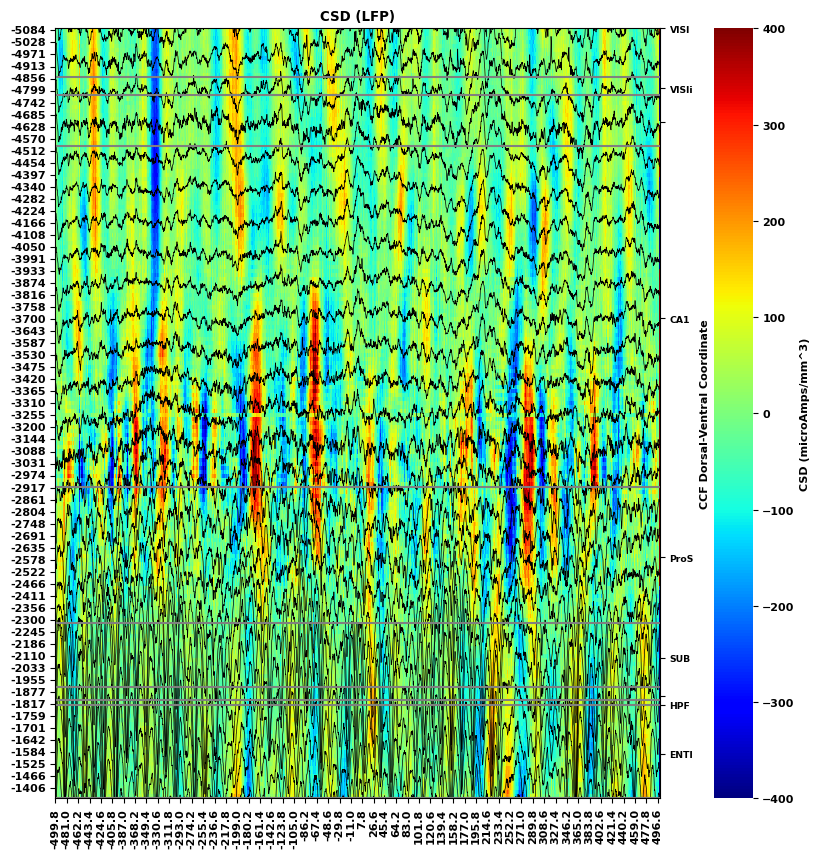

In [102]:
offset = 0.5
event_mask = (lfp_time_index_og >= (desired_event.global_peak_time - offset)) & (
    lfp_time_index_og <= (desired_event.global_peak_time + offset)
)

lfp_slice = destriped[:, event_mask]
time_slice = lfp_time_index_og[event_mask]

lfp_slice = lfp_slice * 1000000
current_sink_this_rip = compute_csd(
    lfp_slice.T, spacing_between_channels=20, chan_rows=channels["rawInd"]
)
# time (x) in miliseconds from middle of ripple envelope, should move to using ripple peak time
rippeaktime = desired_event.global_peak_time
time_ripple_centered_ms = time_slice - desired_event.global_peak_time
time_ripple_centered_ms = time_ripple_centered_ms * 1000
time_ripple_centered_ms = [round(x, 1) for x in time_ripple_centered_ms]

# plotting
scaled_filtered_smoothed_csd = np.transpose(current_sink_this_rip)
# so it's orientated from cortical surface
scaled_filtered_smoothed_csd = np.flip(scaled_filtered_smoothed_csd, axis=0)
sig = (
    scaled_filtered_smoothed_csd.shape[1] / 10.0
)  # Proportional to the size of the array
# Apply Gaussian smoothing
# scaled_filtered_smoothed_csd = gaussian_filter(scaled_filtered_smoothed_csd, sigma=1)
# scaled_filtered_smoothed_csd = gaussian_filter1d(scaled_filtered_smoothed_csd, sigma=0.8, axis=1) # smoothed only along time
# scaled_filtered_smoothed_csd[scaled_filtered_smoothed_csd>0.03] = 0.03
# scaled_filtered_smoothed_csd[scaled_filtered_smoothed_csd<-0.03] = -0.03

scaled_filtered_smoothed_csd *= 1000000
# scaled_filtered_smoothed_csd = exponential_smoothing_2d(scaled_filtered_smoothed_csd, alpha=0.5, axis=1)
scaled_filtered_smoothed_csd = gaussian_filter1d(
    scaled_filtered_smoothed_csd, sigma=0.8, axis=1
)
scaled_filtered_smoothed_csd[scaled_filtered_smoothed_csd > 400] = 400
scaled_filtered_smoothed_csd[scaled_filtered_smoothed_csd < -400] = -400

# depth (y)
ccf_dorsal_ventral = channels["mlapdv"][:, 2]
allen_ontology_annot_og = channels["allen2017_25um_acronym"]
mask = np.full(current_sink_this_rip.shape[1] * 2, False, dtype=bool)
mask[::2] = True
ccf_dorsal_ventral = ccf_dorsal_ventral[mask]
# ccf_dorsal_ventral = np.flip(ccf_dorsal_ventral)
ccf_dorsal_ventral = [str(x) for x in ccf_dorsal_ventral]
allen_ontology_annot = allen_ontology_annot_og[mask]
# simplify the names...
allen_ontology_annot = [
    (
        ""
        if s.islower()
        else (
            "VISl"
            if "VISl" in s and not "VISli" in s
            else "VISli" if "VISli" in s else "ENTl" if "ENTl" in s else s
        )
    )
    for s in allen_ontology_annot
]

# allen_ontology_annot = np.flip(allen_ontology_annot)
# allen_ontology_annot = allen_ontology_annot.to_numpy()

# y axis subsampling for plotting purposes
ylen = scaled_filtered_smoothed_csd.shape[0]
y_tick_positions = np.linspace(0, ylen - 1, int(ylen / 10), dtype=int)
xlen = scaled_filtered_smoothed_csd.shape[1]
x_tick_positions = np.linspace(0, xlen - 1, int(xlen / 10), dtype=int)


plt.figure(figsize=(10 * offset * 2, 10))
scaled_filtered_smoothed_csd = pd.DataFrame(scaled_filtered_smoothed_csd)
scaled_filtered_smoothed_csd.index = ccf_dorsal_ventral
scaled_filtered_smoothed_csd.columns = time_ripple_centered_ms

# Add your heatmap code here
heatmap = sns.heatmap(
    scaled_filtered_smoothed_csd, cbar_kws={"pad": 0.07}, fmt=".2f", cmap="jet"
)  # "Spectral_r" or "vlag" # RdYlBu_r


# Get the range of the heatmap's y-axis
ymin, ymax = plt.gca().get_ylim()

# Downsample the traces further by taking one in every nth probe
nth_probe = 8
trace_arr = lfp_slice[1::nth_probe]

# Calculate the standard deviation of the whole lfp_slice array
std_dev = np.std(lfp_slice)

# Compute the median for each row in the DataFrame
trace_medians = np.median(trace_arr, axis=1)

for i, trace in enumerate(trace_arr):

    # Subtract the median from the trace
    trace = trace - trace_medians[i]

    # Normalize the trace so that a value of the standard deviation of the whole lfp_slice array occupies half of the total space allotted to the trace
    trace = trace / (2 * std_dev)

    # Rescale the trace to fit within its allotted space on the y-axis
    trace = trace * nth_probe

    # Adjust the y-coordinates of the trace to confine it to the channel's position on the plot
    trace = (
        trace + i * nth_probe
    )  # multiply by nth_probe to match the original channel position

    plt.plot(range(len(trace)), trace, color="black", linewidth=0.5)

# Calculate the midpoints of each stretch of the same label and the labels for these midpoints
midpoints = []
labels = []
start = 0
for i in range(1, len(allen_ontology_annot)):
    if allen_ontology_annot[i] != allen_ontology_annot[i - 1]:
        midpoints.append((start + i - 1) / 2)
        labels.append(allen_ontology_annot[start])
        start = i
midpoints.append((start + len(allen_ontology_annot)) / 2)
labels.append(allen_ontology_annot[start])

# Set the y-axis labels and positions for the secondary y-axis
ax2 = heatmap.twinx()
ax2.set_yticks(midpoints)
ax2.set_yticklabels(labels, fontsize="small")

# Find the indices where the label changes
change_indices = np.where(np.roll(allen_ontology_annot, 1) != allen_ontology_annot)[0]

# Draw horizontal lines at these indices
for idx in change_indices:
    plt.axhline(y=idx, color="grey")

plt.title("CSD (LFP)")
plt.xlabel("Time from ripple center time (ms)")
plt.ylabel("CCF Dorsal-Ventral Coordinate")

heatmap.collections[0].colorbar.set_label("CSD (microAmps/mm^3)")
filepathandname = "/home/acampbell/NeuropixelsLFPOnRamp/Figures_and_Technical_Validation/figures/figure1/figure_three_d.svg"
plt.savefig(filepathandname, format="svg")
plt.show()

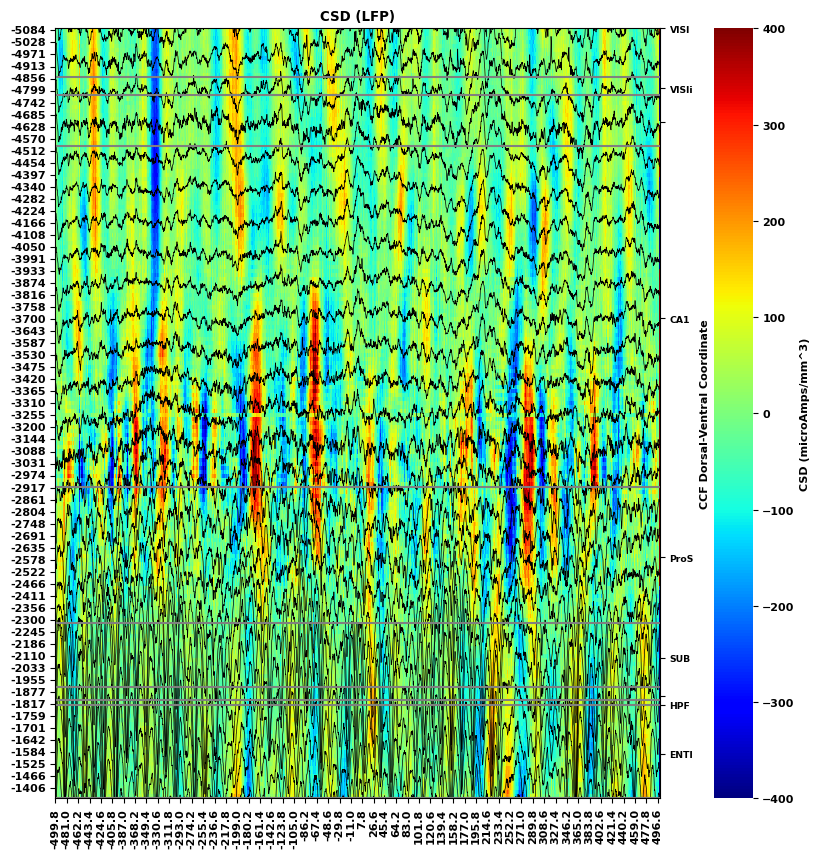

In [103]:
offset = 0.5
event_mask = (lfp_time_index_og >= (desired_event.global_peak_time - offset)) & (
    lfp_time_index_og <= (desired_event.global_peak_time + offset)
)

lfp_slice = destriped[:, event_mask]
time_slice = lfp_time_index_og[event_mask]

lfp_slice = lfp_slice * 1000000
current_sink_this_rip = compute_csd(
    lfp_slice.T, spacing_between_channels=20, chan_rows=channels["rawInd"]
)
# time (x) in miliseconds from middle of ripple envelope, should move to using ripple peak time
rippeaktime = desired_event.global_peak_time
time_ripple_centered_ms = time_slice - desired_event.global_peak_time
time_ripple_centered_ms = time_ripple_centered_ms * 1000
time_ripple_centered_ms = [round(x, 1) for x in time_ripple_centered_ms]

# plotting
scaled_filtered_smoothed_csd = np.transpose(current_sink_this_rip)
# so it's orientated from cortical surface
scaled_filtered_smoothed_csd = np.flip(scaled_filtered_smoothed_csd, axis=0)
sig = (
    scaled_filtered_smoothed_csd.shape[1] / 10.0
)  # Proportional to the size of the array
# Apply Gaussian smoothing
# scaled_filtered_smoothed_csd = gaussian_filter(scaled_filtered_smoothed_csd, sigma=1)
# scaled_filtered_smoothed_csd = gaussian_filter1d(scaled_filtered_smoothed_csd, sigma=0.8, axis=1) # smoothed only along time
# scaled_filtered_smoothed_csd[scaled_filtered_smoothed_csd>0.03] = 0.03
# scaled_filtered_smoothed_csd[scaled_filtered_smoothed_csd<-0.03] = -0.03

scaled_filtered_smoothed_csd *= 1000000
# scaled_filtered_smoothed_csd = exponential_smoothing_2d(scaled_filtered_smoothed_csd, alpha=0.5, axis=1)
scaled_filtered_smoothed_csd = gaussian_filter1d(
    scaled_filtered_smoothed_csd, sigma=0.8, axis=1
)
scaled_filtered_smoothed_csd[scaled_filtered_smoothed_csd > 400] = 400
scaled_filtered_smoothed_csd[scaled_filtered_smoothed_csd < -400] = -400

# depth (y)
ccf_dorsal_ventral = channels["mlapdv"][:, 2]
allen_ontology_annot_og = channels["allen2017_25um_acronym"]
mask = np.full(current_sink_this_rip.shape[1] * 2, False, dtype=bool)
mask[::2] = True
ccf_dorsal_ventral = ccf_dorsal_ventral[mask]
# ccf_dorsal_ventral = np.flip(ccf_dorsal_ventral)
ccf_dorsal_ventral = [str(x) for x in ccf_dorsal_ventral]
allen_ontology_annot = allen_ontology_annot_og[mask]
# simplify the names...
allen_ontology_annot = [
    (
        ""
        if s.islower()
        else (
            "VISl"
            if "VISl" in s and not "VISli" in s
            else "VISli" if "VISli" in s else "ENTl" if "ENTl" in s else s
        )
    )
    for s in allen_ontology_annot
]

# allen_ontology_annot = np.flip(allen_ontology_annot)
# allen_ontology_annot = allen_ontology_annot.to_numpy()

# y axis subsampling for plotting purposes
ylen = scaled_filtered_smoothed_csd.shape[0]
y_tick_positions = np.linspace(0, ylen - 1, int(ylen / 10), dtype=int)
xlen = scaled_filtered_smoothed_csd.shape[1]
x_tick_positions = np.linspace(0, xlen - 1, int(xlen / 10), dtype=int)


plt.figure(figsize=(10 * offset * 2, 10))
scaled_filtered_smoothed_csd = pd.DataFrame(scaled_filtered_smoothed_csd)
scaled_filtered_smoothed_csd.index = ccf_dorsal_ventral
scaled_filtered_smoothed_csd.columns = time_ripple_centered_ms

# Add your heatmap code here
heatmap = sns.heatmap(
    scaled_filtered_smoothed_csd, cbar_kws={"pad": 0.07}, fmt=".2f", cmap="jet"
)  # "Spectral_r" or "vlag" # RdYlBu_r


# Get the range of the heatmap's y-axis
ymin, ymax = plt.gca().get_ylim()

# Downsample the traces further by taking one in every nth probe
nth_probe = 8
trace_arr = lfp_slice[1::nth_probe]

# Calculate the standard deviation of the whole lfp_slice array
std_dev = np.std(lfp_slice)

# Compute the median for each row in the DataFrame
trace_medians = np.median(trace_arr, axis=1)

for i, trace in enumerate(trace_arr):

    # Subtract the median from the trace
    trace = trace - trace_medians[i]

    # Normalize the trace so that a value of the standard deviation of the whole lfp_slice array occupies half of the total space allotted to the trace
    trace = trace / (2 * std_dev)

    # Rescale the trace to fit within its allotted space on the y-axis
    trace = trace * nth_probe

    # Adjust the y-coordinates of the trace to confine it to the channel's position on the plot
    trace = (
        trace + i * nth_probe
    )  # multiply by nth_probe to match the original channel position

    plt.plot(range(len(trace)), trace, color="black", linewidth=0.5)

# Calculate the midpoints of each stretch of the same label and the labels for these midpoints
midpoints = []
labels = []
start = 0
for i in range(1, len(allen_ontology_annot)):
    if allen_ontology_annot[i] != allen_ontology_annot[i - 1]:
        midpoints.append((start + i - 1) / 2)
        labels.append(allen_ontology_annot[start])
        start = i
midpoints.append((start + len(allen_ontology_annot)) / 2)
labels.append(allen_ontology_annot[start])

# Set the y-axis labels and positions for the secondary y-axis
ax2 = heatmap.twinx()
ax2.set_yticks(midpoints)
ax2.set_yticklabels(labels, fontsize="small")

# Find the indices where the label changes
change_indices = np.where(np.roll(allen_ontology_annot, 1) != allen_ontology_annot)[0]

# Draw horizontal lines at these indices
for idx in change_indices:
    plt.axhline(y=idx, color="grey")

plt.title("CSD (LFP)")
plt.xlabel("Time from ripple center time (ms)")
plt.ylabel("CCF Dorsal-Ventral Coordinate")

heatmap.collections[0].colorbar.set_label("CSD (microAmps/mm^3)")
# filepathandname = '/home/acampbell/NeuropixelsLFPOnRamp/Figures_and_Technical_Validation/figures/figure1/figure_three_d.svg'
# plt.savefig(filepathandname, format='svg')
# plt.show()
filepathandname = "/home/acampbell/NeuropixelsLFPOnRamp/Figures_and_Technical_Validation/figures/figure1/figure_one_d.jpg"
plt.savefig(filepathandname, format="jpg")
plt.show()

In [104]:
channels.keys()

dict_keys(['brainLocationIds_ccf_2017', 'labels', 'localCoordinates', 'mlapdv', 'rawInd', 'allen2017_25um_acronym'])

In [105]:
# ibl coordinates and ABI region annotiation
collectionname = (
    f"alf/{probe_name}/pykilosort"  # ensures channels are all from this probe
)
channels = one.load_object(session_id, "channels", collection=collectionname)
channels.allen2017_25um_acronym = br.id2acronym(channels["brainLocationIds_ccf_2017"])

ssl = SpikeSortingLoader(pid=desired_event.peak_probe, one=one, atlas=ba)
channels_ssl = ssl.load_channels()
xyz = np.c_[channels_ssl["x"], channels_ssl["y"], channels_ssl["z"]]


ccf_dorsal_ventral = channels["mlapdv"][:, 2]
ccf_dorsal_ventral = ccf_dorsal_ventral * -1
allen_ontology_annot_og = channels["allen2017_25um_acronym"]
mask = np.full(current_sink_this_rip.shape[1] * 2, False, dtype=bool)
mask[::2] = True
ccf_dorsal_ventral = ccf_dorsal_ventral[mask]
# ccf_dorsal_ventral = np.flip(ccf_dorsal_ventral)
ccf_dorsal_ventral = [str(x) for x in ccf_dorsal_ventral]
allen_ontology_annot = allen_ontology_annot_og[mask]
# simplify the names...
allen_ontology_annot = [
    (
        ""
        if s.islower()
        else (
            "VISl"
            if "VISl" in s and not "VISli" in s
            else "VISli" if "VISli" in s else "ENTl" if "ENTl" in s else s
        )
    )
    for s in allen_ontology_annot
]
indices = np.char.find(allen_ontology_annot_og.astype(str), "VIS")
surface_index = np.where(indices != -1)[0].max()
surface_of_cortex = xyz[surface_index, 2]
depth_of_first_cortical_channel_mm = np.abs(surface_of_cortex) - np.abs(xyz[mask, 2])
depth_of_first_cortical_channel_mm = (
    1000 * depth_of_first_cortical_channel_mm
)  # making it negative and in mm not microns
depth_of_first_cortical_channel_mm = np.round(depth_of_first_cortical_channel_mm, 2)
depth_of_first_cortical_channel_mm

array([-3.72, -3.7 , -3.68, -3.66, -3.64, -3.62, -3.6 , -3.58, -3.57,
       -3.55, -3.53, -3.51, -3.49, -3.47, -3.45, -3.43, -3.41, -3.39,
       -3.37, -3.36, -3.34, -3.32, -3.3 , -3.28, -3.26, -3.24, -3.22,
       -3.2 , -3.18, -3.16, -3.14, -3.13, -3.11, -3.09, -3.07, -3.05,
       -3.03, -3.01, -2.99, -2.97, -2.95, -2.93, -2.92, -2.9 , -2.88,
       -2.86, -2.84, -2.82, -2.8 , -2.78, -2.76, -2.74, -2.72, -2.7 ,
       -2.68, -2.66, -2.64, -2.62, -2.6 , -2.58, -2.57, -2.55, -2.53,
       -2.51, -2.49, -2.47, -2.45, -2.43, -2.41, -2.39, -2.37, -2.35,
       -2.33, -2.31, -2.3 , -2.28, -2.26, -2.24, -2.22, -2.2 , -2.18,
       -2.16, -2.14, -2.13, -2.11, -2.09, -2.07, -2.05, -2.04, -2.02,
       -2.  , -1.98, -1.96, -1.94, -1.92, -1.91, -1.89, -1.87, -1.85,
       -1.83, -1.81, -1.8 , -1.78, -1.76, -1.74, -1.72, -1.7 , -1.68,
       -1.66, -1.64, -1.63, -1.61, -1.59, -1.57, -1.55, -1.53, -1.51,
       -1.49, -1.48, -1.46, -1.44, -1.42, -1.4 , -1.38, -1.36, -1.34,
       -1.32, -1.3 ,

In [106]:
xyz

array([[-0.003878, -0.003955, -0.005084],
       [-0.003878, -0.003955, -0.005084],
       [-0.003875, -0.003949, -0.005066],
       ...,
       [-0.003543, -0.003104, -0.001387],
       [-0.003541, -0.003102, -0.001367],
       [-0.003541, -0.003102, -0.001367]])

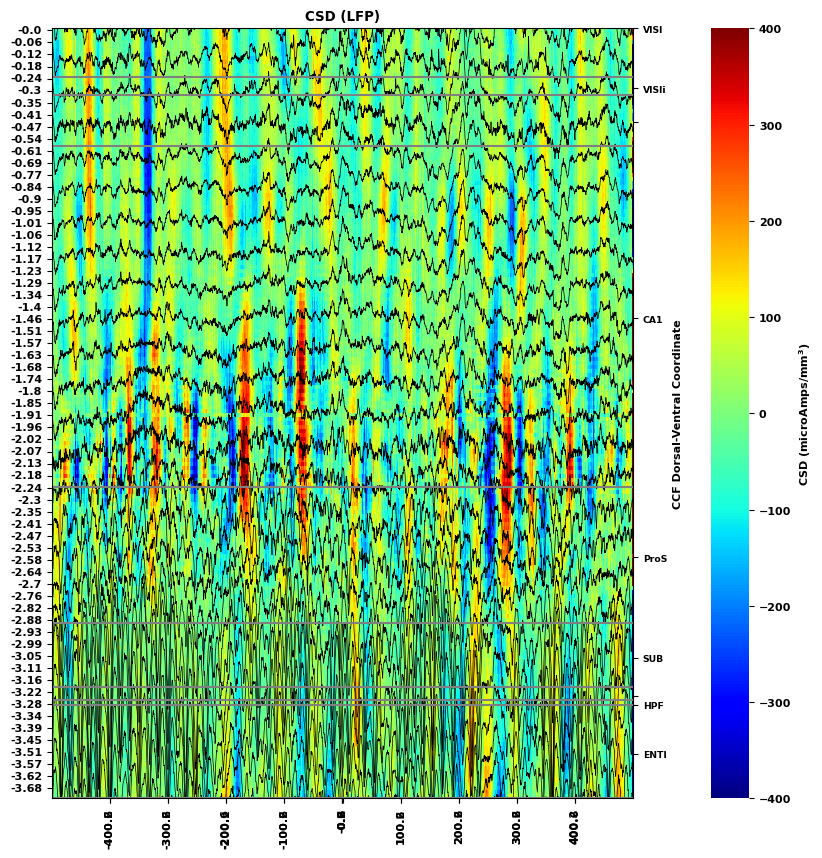

In [107]:
offset = 0.5
event_mask = (lfp_time_index_og >= (desired_event.global_peak_time - offset)) & (
    lfp_time_index_og <= (desired_event.global_peak_time + offset)
)

lfp_slice = destriped[:, event_mask]
time_slice = lfp_time_index_og[event_mask]

lfp_slice = lfp_slice * 1000000
current_sink_this_rip = compute_csd(
    lfp_slice.T, spacing_between_channels=20, chan_rows=channels["rawInd"]
)
# time (x) in miliseconds from middle of ripple envelope, should move to using ripple peak time
rippeaktime = desired_event.global_peak_time
time_ripple_centered_ms = time_slice - desired_event.global_peak_time
time_ripple_centered_ms = time_ripple_centered_ms * 1000
time_ripple_centered_ms = [round(x, 1) for x in time_ripple_centered_ms]

# plotting
scaled_filtered_smoothed_csd = np.transpose(current_sink_this_rip)
# so it's orientated from cortical surface
scaled_filtered_smoothed_csd = np.flip(scaled_filtered_smoothed_csd, axis=0)
sig = (
    scaled_filtered_smoothed_csd.shape[1] / 10.0
)  # Proportional to the size of the array
# Apply Gaussian smoothing
# scaled_filtered_smoothed_csd = gaussian_filter(scaled_filtered_smoothed_csd, sigma=1)
# scaled_filtered_smoothed_csd = gaussian_filter1d(scaled_filtered_smoothed_csd, sigma=0.8, axis=1) # smoothed only along time
# scaled_filtered_smoothed_csd[scaled_filtered_smoothed_csd>0.03] = 0.03
# scaled_filtered_smoothed_csd[scaled_filtered_smoothed_csd<-0.03] = -0.03

scaled_filtered_smoothed_csd *= 1000000
# scaled_filtered_smoothed_csd = exponential_smoothing_2d(scaled_filtered_smoothed_csd, alpha=0.5, axis=1)
scaled_filtered_smoothed_csd = gaussian_filter1d(
    scaled_filtered_smoothed_csd, sigma=0.8, axis=1
)
scaled_filtered_smoothed_csd[scaled_filtered_smoothed_csd > 400] = 400
scaled_filtered_smoothed_csd[scaled_filtered_smoothed_csd < -400] = -400

# ibl coordinates and ABI region annotiation
collectionname = (
    f"alf/{probe_name}/pykilosort"  # ensures channels are all from this probe
)
channels = one.load_object(session_id, "channels", collection=collectionname)
channels.allen2017_25um_acronym = br.id2acronym(channels["brainLocationIds_ccf_2017"])

# for computing depth from surface
ssl = SpikeSortingLoader(pid=desired_event.peak_probe, one=one, atlas=ba)
channels_ssl = ssl.load_channels()
xyz = np.c_[channels_ssl["x"], channels_ssl["y"], channels_ssl["z"]]


ccf_dorsal_ventral = channels["mlapdv"][:, 2]
ccf_dorsal_ventral = ccf_dorsal_ventral * -1
allen_ontology_annot_og = channels["allen2017_25um_acronym"]
mask = np.full(current_sink_this_rip.shape[1] * 2, False, dtype=bool)
mask[::2] = True
ccf_dorsal_ventral = ccf_dorsal_ventral[mask]
# ccf_dorsal_ventral = np.flip(ccf_dorsal_ventral)
ccf_dorsal_ventral = [str(x) for x in ccf_dorsal_ventral]
allen_ontology_annot = allen_ontology_annot_og[mask]
# simplify the names...
allen_ontology_annot = [
    (
        ""
        if s.islower()
        else (
            "VISl"
            if "VISl" in s and not "VISli" in s
            else "VISli" if "VISli" in s else "ENTl" if "ENTl" in s else s
        )
    )
    for s in allen_ontology_annot
]
indices = np.char.find(allen_ontology_annot_og.astype(str), "VIS")
surface_index = np.where(indices != -1)[0].max()
surface_of_cortex = xyz[surface_index, 2]
depth_of_first_cortical_channel_mm = surface_of_cortex - xyz[mask, 2]
depth_of_first_cortical_channel_mm = (
    -1 * 1000 * depth_of_first_cortical_channel_mm
)  # making it negative and in mm not microns
depth_of_first_cortical_channel_mm = np.flip(
    np.round(depth_of_first_cortical_channel_mm, 2)
)
depth_of_first_cortical_channel_mm = [
    str(x) for x in depth_of_first_cortical_channel_mm
]

# allen_ontology_annot = np.flip(allen_ontology_annot)
# allen_ontology_annot = allen_ontology_annot.to_numpy()

# y axis subsampling for plotting purposes
ylen = scaled_filtered_smoothed_csd.shape[0]
y_tick_positions = np.linspace(0, ylen - 1, int(ylen / 10), dtype=int)
xlen = scaled_filtered_smoothed_csd.shape[1]
x_tick_positions = np.linspace(0, xlen - 1, int(xlen / 10), dtype=int)

# plt.rcParams['svg.fonttype'] = 'none'
# plt.rcParams['text.usetex'] = False  # Do not use LaTeX for rendering text
# plt.rcParams["font.weight"] = "bold"
# plt.rcParams["font.size"] = 8
# plt.rcParams["axes.titleweight"] = "bold"  # Make the title bold
# plt.rcParams["axes.labelweight"] = "bold"

plt.figure(figsize=(10 * offset * 2, 10))
scaled_filtered_smoothed_csd = pd.DataFrame(scaled_filtered_smoothed_csd)
# scaled_filtered_smoothed_csd.index = ccf_dorsal_ventral
scaled_filtered_smoothed_csd.index = depth_of_first_cortical_channel_mm
scaled_filtered_smoothed_csd.columns = time_ripple_centered_ms

# Add your heatmap code here
heatmap = sns.heatmap(
    scaled_filtered_smoothed_csd, cbar_kws={"pad": 0.1}, fmt=".2f", cmap="jet"
)  # "Spectral_r" or "vlag" # RdYlBu_r


# Get the range of the heatmap's y-axis
ymin, ymax = plt.gca().get_ylim()

# Downsample the traces further by taking one in every nth probe
nth_probe = 8
trace_arr = lfp_slice[1::nth_probe]

# Calculate the standard deviation of the whole lfp_slice array
std_dev = np.std(lfp_slice)

# Compute the median for each row in the DataFrame
trace_medians = np.median(trace_arr, axis=1)

for i, trace in enumerate(trace_arr):

    # Subtract the median from the trace
    trace = trace - trace_medians[i]

    # Normalize the trace so that a value of the standard deviation of the whole lfp_slice array occupies half of the total space allotted to the trace
    trace = trace / (2 * std_dev)

    # Rescale the trace to fit within its allotted space on the y-axis
    trace = trace * nth_probe

    # Adjust the y-coordinates of the trace to confine it to the channel's position on the plot
    trace = (
        trace + i * nth_probe
    )  # multiply by nth_probe to match the original channel position

    plt.plot(range(len(trace)), trace, color="black", linewidth=0.5)

# Calculate the midpoints of each stretch of the same label and the labels for these midpoints
midpoints = []
labels = []
start = 0
for i in range(1, len(allen_ontology_annot)):
    if allen_ontology_annot[i] != allen_ontology_annot[i - 1]:
        midpoints.append((start + i - 1) / 2)
        labels.append(allen_ontology_annot[start])
        start = i
midpoints.append((start + len(allen_ontology_annot)) / 2)
labels.append(allen_ontology_annot[start])

# Set the y-axis labels and positions for the secondary y-axis
ax2 = heatmap.twinx()
ax2.set_yticks(midpoints)
ax2.set_yticklabels(labels, fontsize="small")
ax2.set_ylabel("Cortical depth")  # Add y-axis label on the right


# Find the indices where the label changes
change_indices = np.where(np.roll(allen_ontology_annot, 1) != allen_ontology_annot)[0]

# Draw horizontal lines at these indices
for idx in change_indices:
    plt.axhline(y=idx, color="grey")

plt.title("CSD (LFP)")
plt.xlabel("Time from ripple center time (ms)")
# plt.ylabel("CCF Dorsal-Ventral Coordinate")
label = plt.ylabel("CCF Dorsal-Ventral Coordinate")
label.set_position((2, 0.5))

heatmap.collections[0].colorbar.set_label("CSD (microAmps/mm$^3$)")

# Calculate the positions for x-ticks that are multiples of 100
x_tick_positions = [
    i for i, x in enumerate(time_ripple_centered_ms) if int(x) % 100 == 0
]

# Set the x-ticks to these positions
plt.xticks(
    ticks=x_tick_positions,
    labels=[time_ripple_centered_ms[i] for i in x_tick_positions],
)

# filepathandname = '/home/acampbell/NeuropixelsLFPOnRamp/TechnicalValidation/figures/figure1/figure_three_d_2.svg'
# plt.savefig(filepathandname, format='svg')
filepathandname = "/home/acampbell/NeuropixelsLFPOnRamp/Figures_and_Technical_Validation/figures/figure1/figure_one_d_2.jpg"
# plt.savefig(filepathandname, format='jpg', dpi=300)
plt.show()